"""
欄位結構說明，整合三平台用
unified_columns = [
    'system_id',    # key值
    'dataSource',   # 平台來源（YT/PTT/IG）
    'artUrl',       # 內容連結
    'artDate',      # 發布時間（統一格式）
    'artTitle',     # 標題
    'artContent',   # 內容文字
    'artPoster',    # 作者/發布者
    'artPosterUrl', # 作者連結
    'comments',     # 評論內容
    'commentcount', # 評論數量
    'likecount',    # 點讚數
    'category',     # 分類/版面/類型
    'media_type'    # 媒體類型（影片/圖片/文字/混合）
]
"""

0.導入必要的套件

In [1]:
# 基本資料處理
import os, re
from datetime import datetime
from collections import Counter, namedtuple, defaultdict
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple, Set
from math import log

# 文字處理與 NLP
import jieba, jieba.posseg as pseg, jieba.analyse
from snownlp import SnowNLP
from nltk import ngrams, FreqDist
from gensim import corpora, models
from wordcloud import WordCloud

# 機器學習
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE  # 用於降維可視化
from sklearn.model_selection import train_test_split

# 視覺化
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px

# 繪圖設定
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

# 設定繪圖環境
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')


1. 資料讀取與整合

In [39]:
# 讀取三平台資料
yt = pd.read_csv('chiikawa_data/chiikawa_yt_data.csv')
ptt = pd.read_csv('chiikawa_data/chiikawa_ptt_data.csv')
ig = pd.read_csv('chiikawa_data/chiikawa_ig_data.csv')

# 欄位統一與補齊
yt_df = pd.DataFrame({
    'system_id': yt['system_id'],
    'dataSource': yt['dataSource'],
    'artUrl': yt['artUrl'],
    'artDate': pd.to_datetime(yt['artDate']),
    'artTitle': yt['artTitle'],
    'artContent': yt['artContent'],
    'artPoster': yt['artPoster'],
    'artPosterUrl': yt['artPosterUrl'],
    'commentcount': yt['commentcount'],
    'likecount': yt['likecount'],
    'category': ''  # YouTube無分類
})

ptt_df = pd.DataFrame({
    'system_id': ptt['system_id'],
    'dataSource': ptt['dataSource'],
    'artUrl': ptt['artUrl'],
    'artDate': pd.to_datetime(ptt['artDate']),
    'artTitle': ptt['artTitle'],
    'artContent': ptt['artContent'],
    'artPoster': ptt['artPoster'],
    'artPosterUrl': '',  # 無此欄
    'commentcount': ptt['artComment'].apply(lambda x: x.count('推') + x.count('噓') + x.count('→') if pd.notna(x) else 0),
    'likecount': 0,  # 無like數，要用commentcount去算
    'category': ptt['artCatagory']
})

ig_df = pd.DataFrame({
    'system_id': ig['system_id'],
    'dataSource': ig['dataSource'],
    'artUrl': ig['artUrl'],
    'artDate': pd.to_datetime(ig['artDate']),
    'artTitle': '',  # IG無標題
    'artContent': ig['artContent'],
    'artPoster': ig['artPoster'],
    'artPosterUrl': ig['artPosterUrl'],
    'commentcount': ig['commentcount'],
    'likecount': ig['likecount'],
    'category': ig['type']
})

# 合併資料並統一資料格式，調整缺失欄位
df = pd.concat([yt_df, ptt_df, ig_df], ignore_index=True)

# 時間格式統一
df['artDate'] = df['artDate'].dt.strftime('%Y-%m-%d %H:%M:%S')

# 缺失值處理
df.fillna('', inplace=True)

# 儲存成一個統一格式，原始檔案有擴充可隨時更新
df.to_csv('chiikawa_unified_data.csv', index=False, encoding='utf-8-sig')

# 檢視合併後的資料
# print(f"合併後資料筆數: {len(df)}")
# print(f"資料欄位: {df.columns.tolist()}")
# print(f"資料樣本:\n{df.head(3)}")

2. 資料預處理與文本清理

In [40]:
# 對文本進行完整的清理
df['clean_content'] = df['artContent'].astype(str)
# 將多個連續換行符替換為句號
df['clean_content'] = df['clean_content'].str.replace(r'\n\n', '。', regex=True)
# 將單個換行符替換為逗號
df['clean_content'] = df['clean_content'].str.replace(r'\n', '，', regex=True)
# 移除網址
df['clean_content'] = df['clean_content'].str.replace(r'http\S+', '', regex=True).str.replace(r'www\S+', '', regex=True)
# 統一標點符號，移除表情符號和特殊符號
df['clean_content'] = df['clean_content'].str.replace(r'[^\u4e00-\u9fff\s.,!?;:、，。！？；：]', '', regex=True)

# 使用正則表達式進行更精確的斷句
def split_sentences(text):
    # 以句號、問號、感嘆號等作為斷句標記
    sentences = re.split(r'[。！？!?]+', text)
    # 移除空字符串和只包含空白的字符串
    return [s.strip() for s in sentences if s.strip()]

df['sentences'] = df['clean_content'].apply(split_sentences)

# 檢視斷句結果
sample_sentences = df[df['sentences'].str.len() > 0].iloc[0]['sentences']
print(f"斷句範例：{sample_sentences[:3]}")  # 顯示前3個句子

斷句範例：['小八跳舞 吉伊卡哇']


3. 設定斷詞引擎和字典-停用詞設定

In [41]:
# 設定jieba的字典和使用者自定義詞典
jieba.set_dictionary('dict/dict.txt.big')  # 使用繁體中文字典

# 新增特定領域詞彙到自定義詞典
custom_words = [
    # 主要名稱
    "Chiikawa", "吉伊卡哇", "ちいかわ", "吉伊", "小可愛", "吉依", "寶寶",
    
    # 主要角色
    "小八貓", "ハチワレ", "Hachiware", "八字瀏海", "小八", "藍色褲頭貓", "哈奇" , "哈吉",
    "兔兔", "うさぎ", "Usagi", "烏薩奇", "兔哥", "537",
    "小桃", "モモンガ", "Momonga", "飛鼠",
    "海獺勇者", "ラッコ", "Rakko",
    "栗子饅頭", "くりまんじゅう", "Kuri-Manjuu", "前輩",
    
    # 其他角色
    "風獅", "シーサー", "Shisa", "獅薩",
    "拉麵鎧甲人", "手拿包鎧甲人", "勞動鎧甲人", "鎧甲人",
    "睡衣派對", "パジャマパーティーズ", "哥布林",
    
    # 特殊詞彙
    "吉伊卡哇構文", "除草考試", "除草檢定", "小可愛族",
    "郎拉麵店", "三級除草證件", "討伐", "抽獎運",
    
    # 特性描述
    "膽小鬼", "愛哭鬼", "療癒", "二頭身", "啊哈", "吖哈",
    "又小又可愛", "なんか小さくてかわいいやつ",
    
    # 創作相關
    "Nagano", "ナガノ", "動畫工房", "周邊商品", "貼圖", "一番賞"
]

for word in custom_words:
    jieba.add_word(word, freq=100)  # 給予較高詞頻以確保能被切分出來

# 建立角色同義詞映射表
character_synonyms = {
    # 主角同義詞映射
    "ちいかわ": "吉伊卡哇", "Chiikawa": "吉伊卡哇", "吉伊": "吉伊卡哇", 
    "小可愛": "吉伊卡哇", "吉依": "吉伊卡哇",
    
    # 小八貓同義詞映射
    "ハチワレ": "小八貓", "Hachiware": "小八貓", "八字瀏海": "小八貓", 
    "小八": "小八貓", "藍色褲頭貓": "小八貓", "哈奇": "小八貓", "哈吉": "小八貓",
    
    # 兔兔同義詞映射
    "うさぎ": "兔兔", "Usagi": "兔兔", "烏薩奇": "兔兔", 
    "兔哥": "兔兔", "537": "兔兔",
    
    # 其他角色同義詞映射
    "モモンガ": "小桃", "Momonga": "小桃", "飛鼠": "小桃",
    "ラッコ": "海獺勇者", "Rakko": "海獺勇者",
    "くりまんじゅう": "栗子饅頭", "Kuri-Manjuu": "栗子饅頭", "前輩": "栗子饅頭",
    "シーサー": "風獅", "Shisa": "風獅", "獅薩": "風獅",
    "パジャマパーティーズ": "睡衣派對", "哥布林": "睡衣派對"
}

# 載入停用詞
def load_stopwords(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            stopwords = [line.strip() for line in f.readlines()]
        return set(stopwords)
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='big5') as f:
            stopwords = [line.strip() for line in f.readlines()]
        return set(stopwords)
    except Exception as e:
        print(f"讀取停用詞檔案時發生錯誤: {e}")
        return set()

# 讀取停用詞
stopwords_path = "./dict/stopwords.txt"  
stopwords = load_stopwords(stopwords_path)
print(f"已載入 {len(stopwords)} 個停用詞")

# 新增自定義停用詞
custom_stopwords = [
    # 代詞
    "我", "你", "他", "她", "它", "我們", "你們", "他們", "她們", "它們", "這", "那", "這些", "那些", "誰", "什麼", "哪", "哪裡", "哪兒", "怎麼", "怎樣", "如何",
    
    # 連接詞
    "和", "與", "而", "並", "或", "但", "但是", "然而", "所以", "因為", "因此", "如果", "雖然", "即使", "無論", "只要", "不論", "假如", "若", "若是",
    
    # 助詞
    "的", "地", "得", "了", "著", "過", "吧", "嗎", "呢", "啊", "哦", "喔", "呀", "耶", "哎", "唉", "嗯", "嘿",
    
    # 副詞
    "很", "非常", "極", "太", "更", "最", "又", "也", "都", "還", "只", "就", "才", "剛", "曾", "已", "將", "不", "沒", "別", "莫", "勿",
    
    # 介詞
    "在", "從", "向", "往", "於", "對", "給", "為", "替", "由", "把", "被", "讓", "使", "隨", "跟", "靠", "據", "至", "到", "自",
    
    # 數量詞
    "一", "二", "三", "四", "五", "六", "七", "八", "九", "十", "百", "千", "萬", "億", "兆", "個", "些", "每", "某", "各", "整", "全", "多", "少", "幾",
    
    # 時間詞
    "年", "月", "日", "時", "分", "秒", "天", "週", "季", "今", "昨", "明", "前", "後", "當", "正", "現", "曾", "已", "將", "會", "常", "永",
    
    # 方位詞
    "上", "下", "左", "右", "前", "後", "內", "外", "中", "東", "西", "南", "北", "中間", "旁邊", "附近", "周圍",
    
    # 常用動詞
    "是", "有", "無", "來", "去", "做", "看", "聽", "說", "想", "要", "能", "會", "可以", "應該", "必須", "需要", "得", "獲", "取", "予",
    
    # 常用形容詞
    "好", "壞", "大", "小", "多", "少", "高", "低", "長", "短", "新", "舊", "快", "慢", "遠", "近", "輕", "重", "深", "淺",
    
    # 其他常見虛詞
    "之", "乎", "以", "其", "所", "者", "矣", "焉", "哉", "也", "然", "否", "兮", "乃", "且", "為", "則", "再", "又", "此", "夫", "亦",
    
    # 常見短語
    "一個", "這個", "那個", "一些", "這些", "那些", "一下", "一點", "一直", "一定", "一般", "一樣", "不過", "不必", "不要", "可能", "可是", "只是", "就是", "如此", "如果", "這樣", "那樣", "這麼", "那麼", "因此", "所以", "然後", "接著", "其實", "其中", "其他", "其它", "之前", "之後", "之中", "之間",
    
    # 網路用語
    "http", "www", "com", "cn", "org", "net", "html", "htm", "php", "jpg", "png", "gif", ".."
]
stopwords.update(custom_stopwords)



Building prefix dict from g:\我的雲端硬碟\I want to graduate I want to graduate\二下\SMA\SMA_final\dict\dict.txt.big ...
Loading model from cache C:\Users\qqw12\AppData\Local\Temp\jieba.u5b75d4bc912d0a353138fdc294f176b2.cache
Loading model cost 1.123 seconds.
Prefix dict has been built successfully.


已載入 1211 個停用詞


4. 詞頻分析

In [42]:
# 基於詞頻分析，識別需要作為整體保留的詞組
new_compounds = [
    # 角色/品牌相關/常見錯誤
    "吉伊卡哇", "烏薩奇", "小八貓", "小可愛", "537", "兔哥", "兔兔", "吉伊", "吉依",
    
    # 地點相關
    "銅鑼灣", "時代廣場", "羅素街號", "羅素街", "三樓",
    
    # 商品/活動相關詞組
    "一番玩具", "代購吉伊卡哇", "電視對面", "時代廣場電視", 
    "購物香港", "日本玩具", "日本動漫", "玩具精品", "銅鑼灣好去處"
]

# 添加同義詞到需要保留的詞組中
for synonym in character_synonyms.keys():
    if synonym not in new_compounds:
        new_compounds.append(synonym)

# 為這些詞組設定較高詞頻，切詞時能被作為整體的字詞識別
for word in new_compounds:
    jieba.add_word(word, freq=1000)  # 給予高詞頻

# 特別處理高頻共現詞組，這些可能是更長的複合詞
high_freq_collocations = [
    ("代購", "吉伊卡哇"),
    ("電視", "對面"),
    ("時代廣場", "電視"),
    ("銅鑼灣", "羅素"),
    ("羅素", "街號"),
    ("街號", "三樓")
]

# 將高頻共現詞組也添加為複合詞
for words in high_freq_collocations:
    compound = "".join(words)
    jieba.add_word(compound, freq=1500)  # 給予更高詞頻

# 針對特定領域詞彙設定更高詞頻
special_terms = ["吉伊卡哇", "烏薩奇", "小八貓", "537"]
for term in special_terms:
    jieba.add_word(term, freq=500)  # 給予最高詞頻，確保不被切分

5. 分詞處理與統計

In [43]:
# 定義統一的改進版分詞函數
def improved_tokenize(text):
    """
    進行斷詞並過濾停用詞和短詞，同時處理同義詞替換
    """
    # 處理 NaN 和空值
    if pd.isna(text) or not isinstance(text, str) or not text.strip():
        return []
    
    # 使用jieba進行斷詞
    words = jieba.lcut(text)
    
    # 過濾停用詞、單字元詞，並進行同義詞替換
    filtered_words = []
    for word in words:
        if word not in stopwords and len(word.strip()) > 1:
            # 同義詞替換
            if word in character_synonyms:
                word = character_synonyms[word]
            filtered_words.append(word)
    
    return filtered_words

# 對每個句子進行分詞
df['tokens'] = df['sentences'].apply(lambda sents: [improved_tokenize(s) for s in sents if s])
df['flat_tokens'] = df['tokens'].apply(lambda token_lists: [token for sublist in token_lists for token in sublist if token])

# 將tokens展開為每個token一行，以利後續分析
df_exploded = df.explode('flat_tokens')
df_exploded = df_exploded[df_exploded['flat_tokens'].str.len() > 0]

# 計算詞頻
word_counts = df_exploded['flat_tokens'].value_counts().reset_index()
word_counts.columns = ['word', 'count']

# 顯示前20個高頻詞
print("前20個高頻詞：")
print(word_counts.head(20))

前20個高頻詞：
    word  count
0   吉伊卡哇  28964
1     日本  11436
2     代購   9272
3     公仔   7858
4     兔兔   6368
5    銅鑼灣   6101
6     可愛   4493
7    小八貓   4146
8     香港   3896
9     玩具   3481
10    喜歡   2973
11    現貨   2897
12    扭蛋   2831
13    購物   2747
14    系列   2589
15    百貨   2539
16    蛋糕   2493
17  時代廣場   2409
18  電視對面   2393
19    追蹤   2355


6. 將詞頻視覺化

<Figure size 1200x800 with 0 Axes>

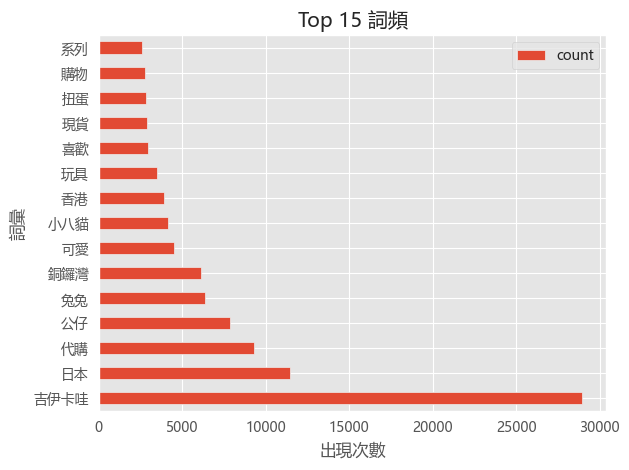

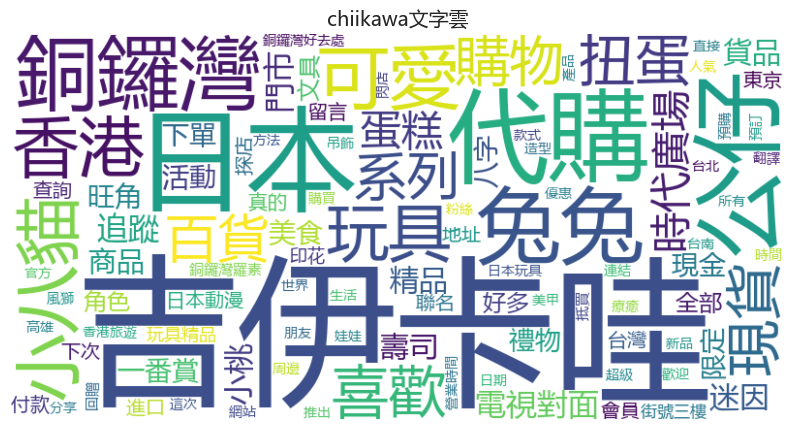

In [44]:
# 繪製詞頻長條圖
plt.figure(figsize=(12, 8))
word_counts.head(15).plot.barh(x='word', y='count')
plt.title('Top 15 詞頻')
plt.xlabel('出現次數')
plt.ylabel('詞彙')
plt.tight_layout()
plt.show()

# 將詞頻轉換為字典格式
word_freq = dict(zip(word_counts['word'], word_counts['count']))

# 使用系統上可用的字體生成文字雲
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    collocations=False,
    font_path=r'C:\Windows\Fonts\msyh.ttc'  # 直接指定系統中的微軟雅黑字體
)
wordcloud.generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('chiikawa文字雲')
plt.show()

7. 情緒分析

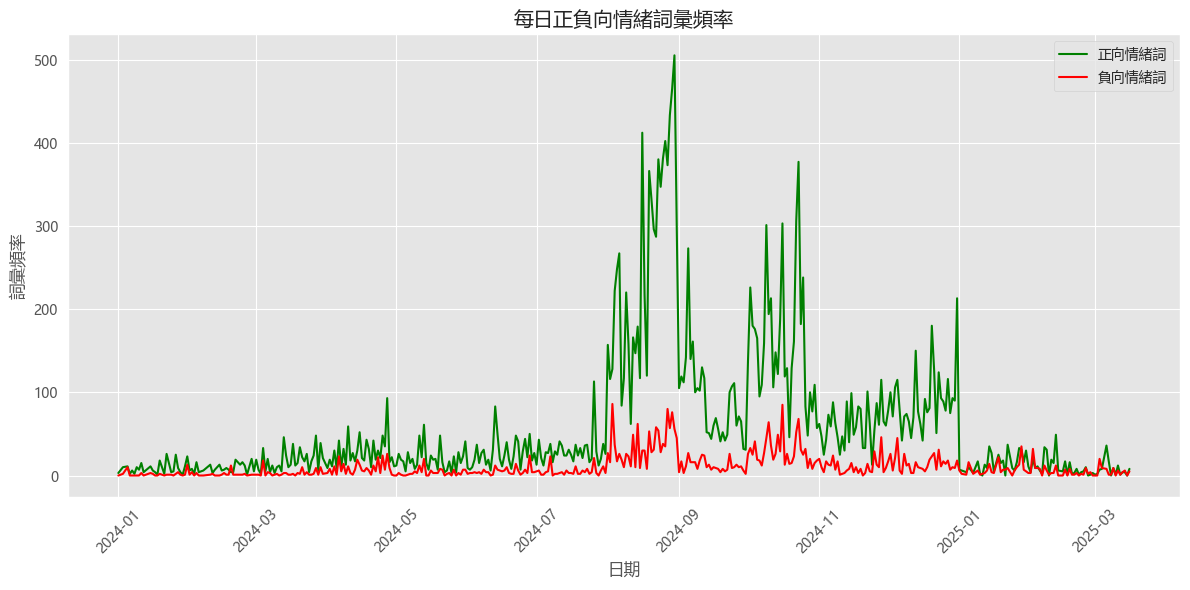

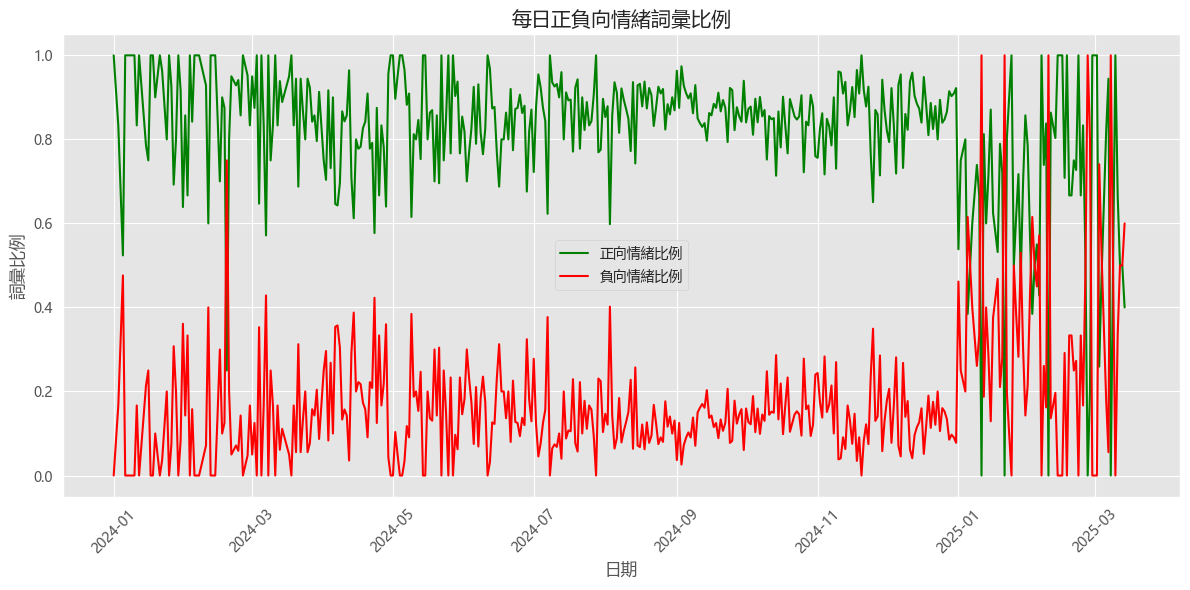

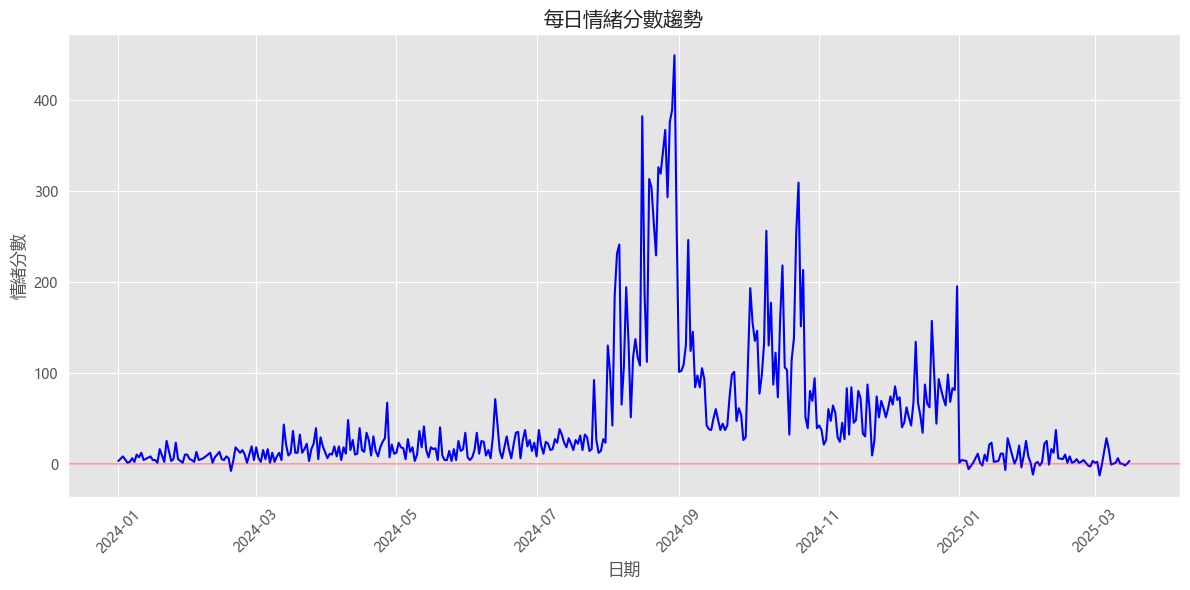

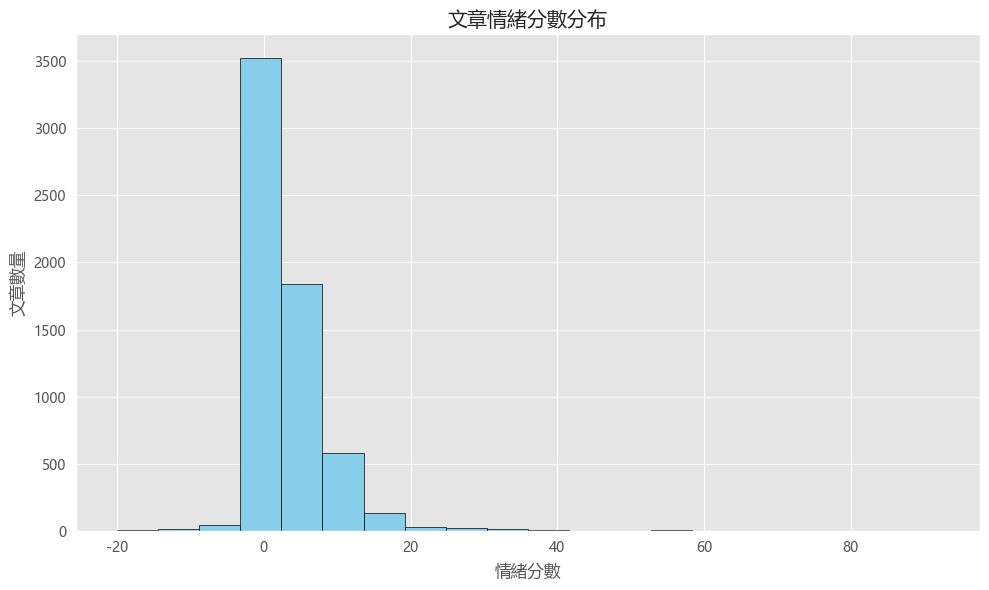

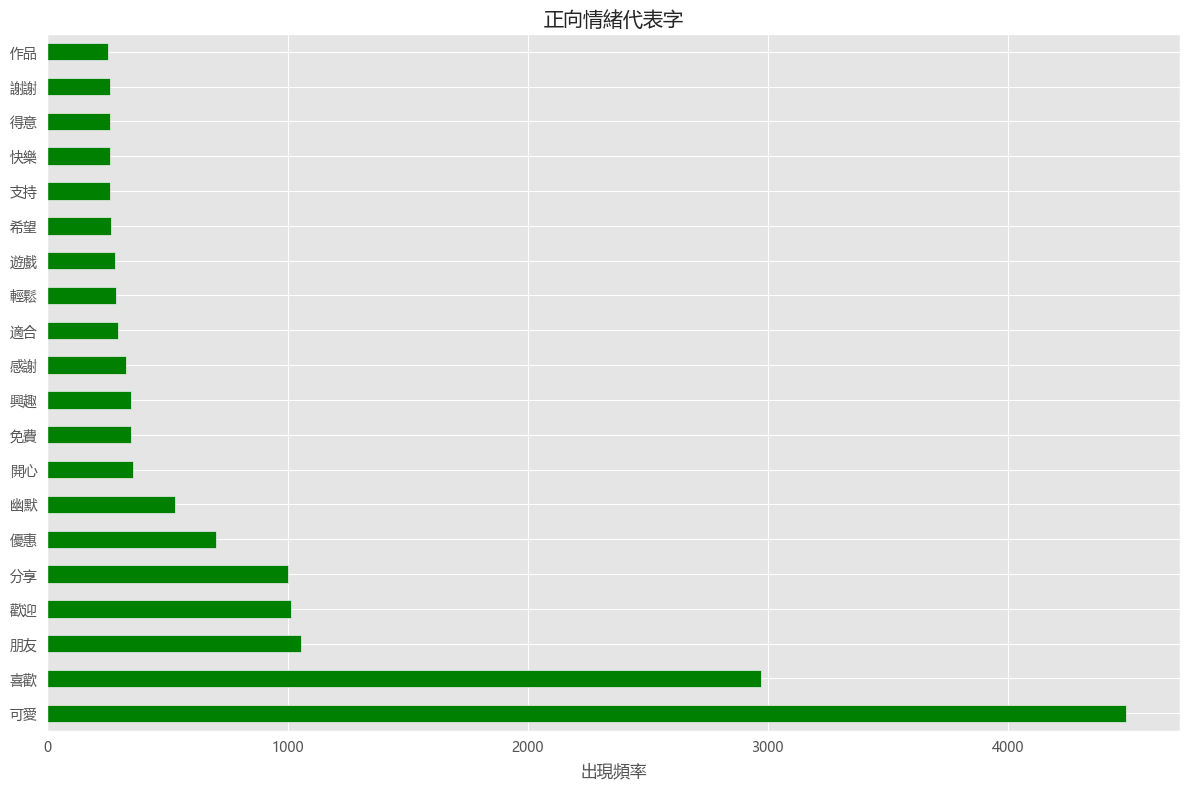

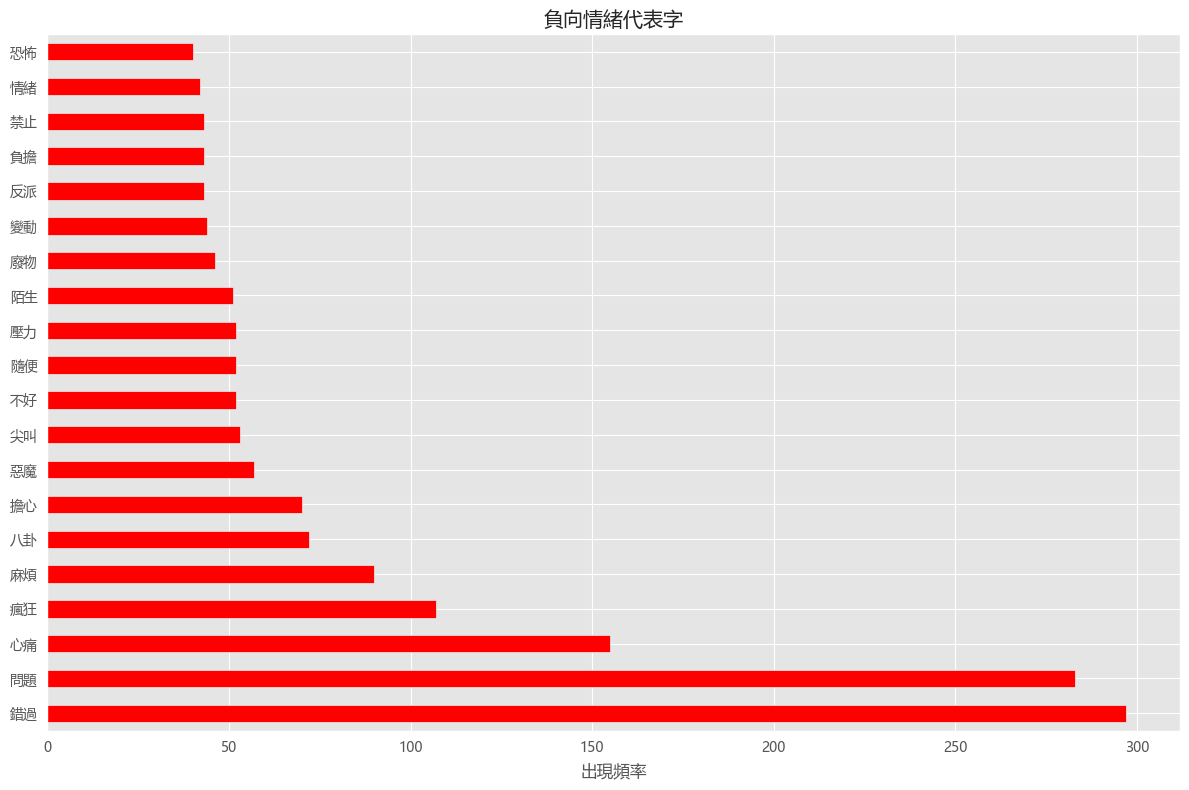

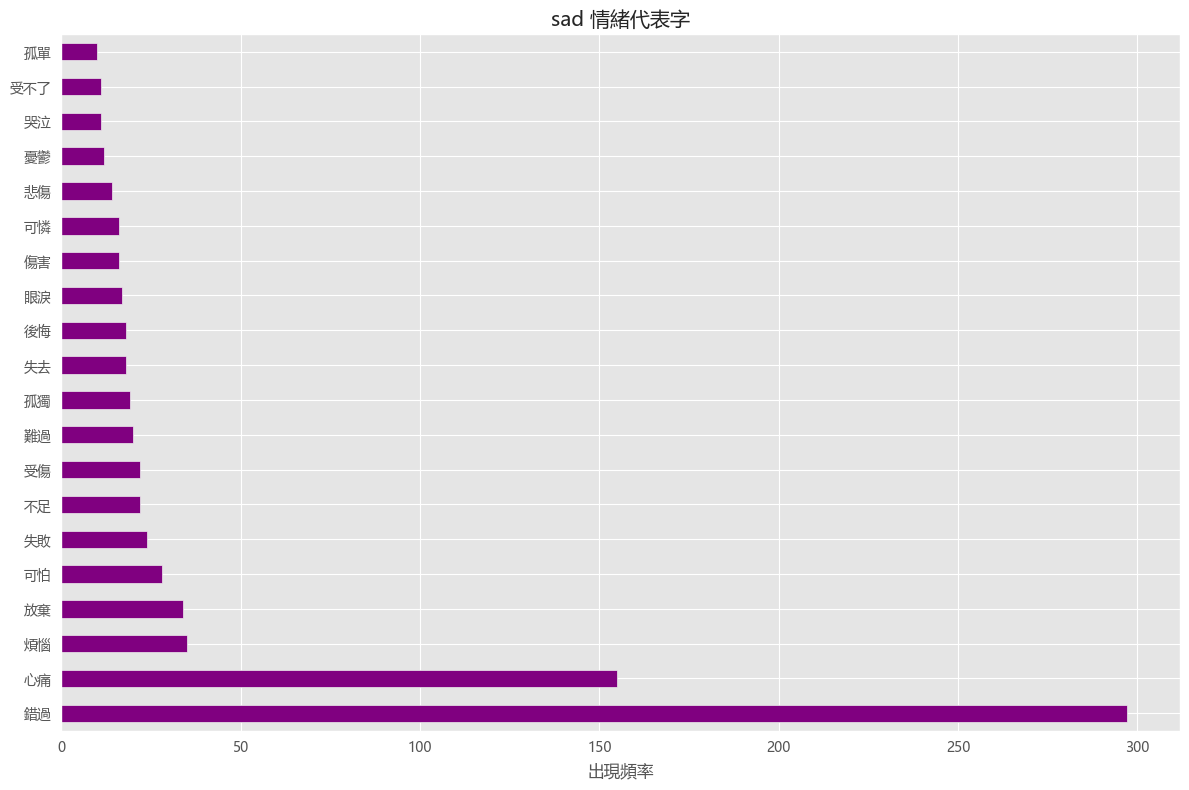

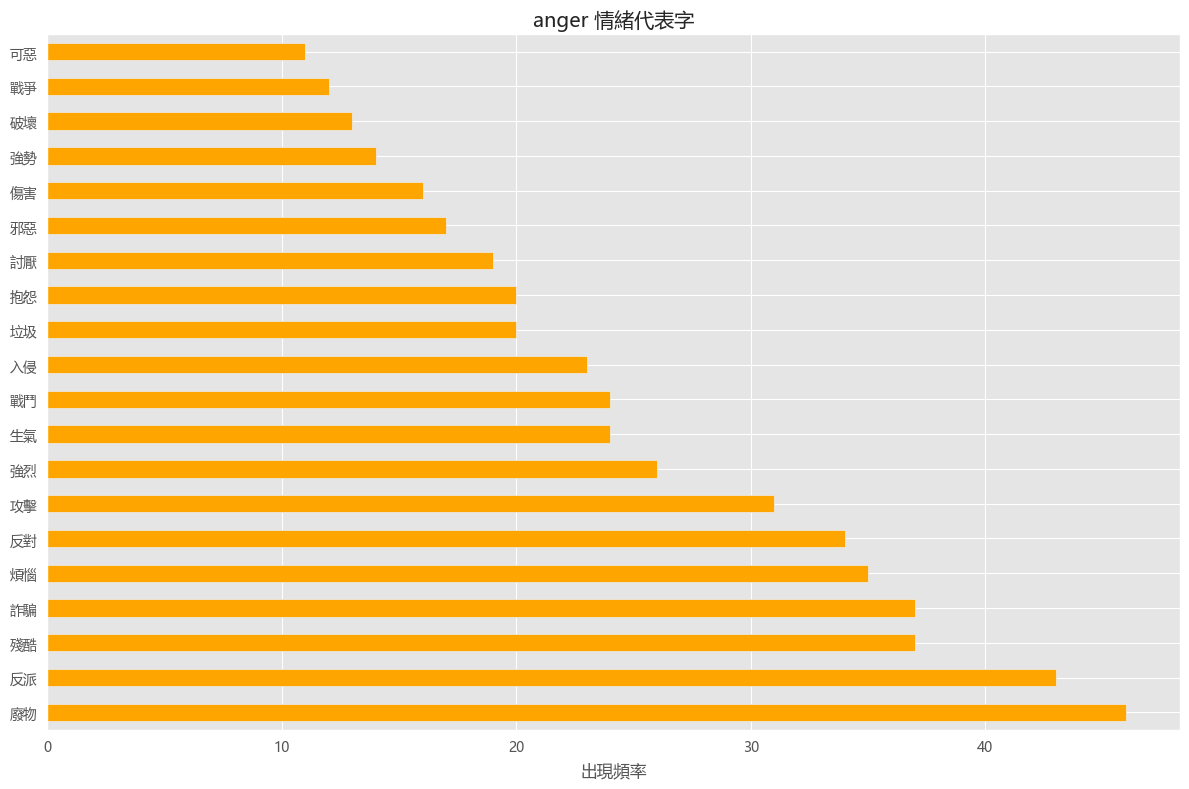

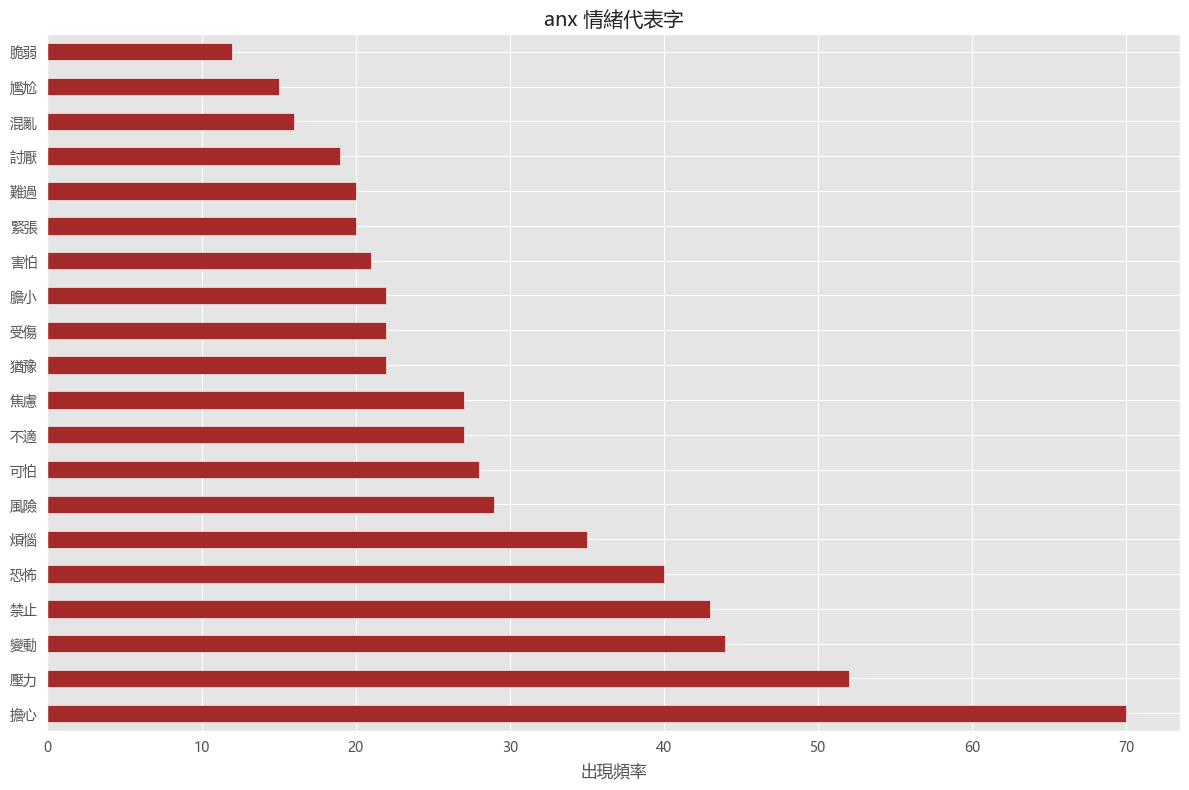

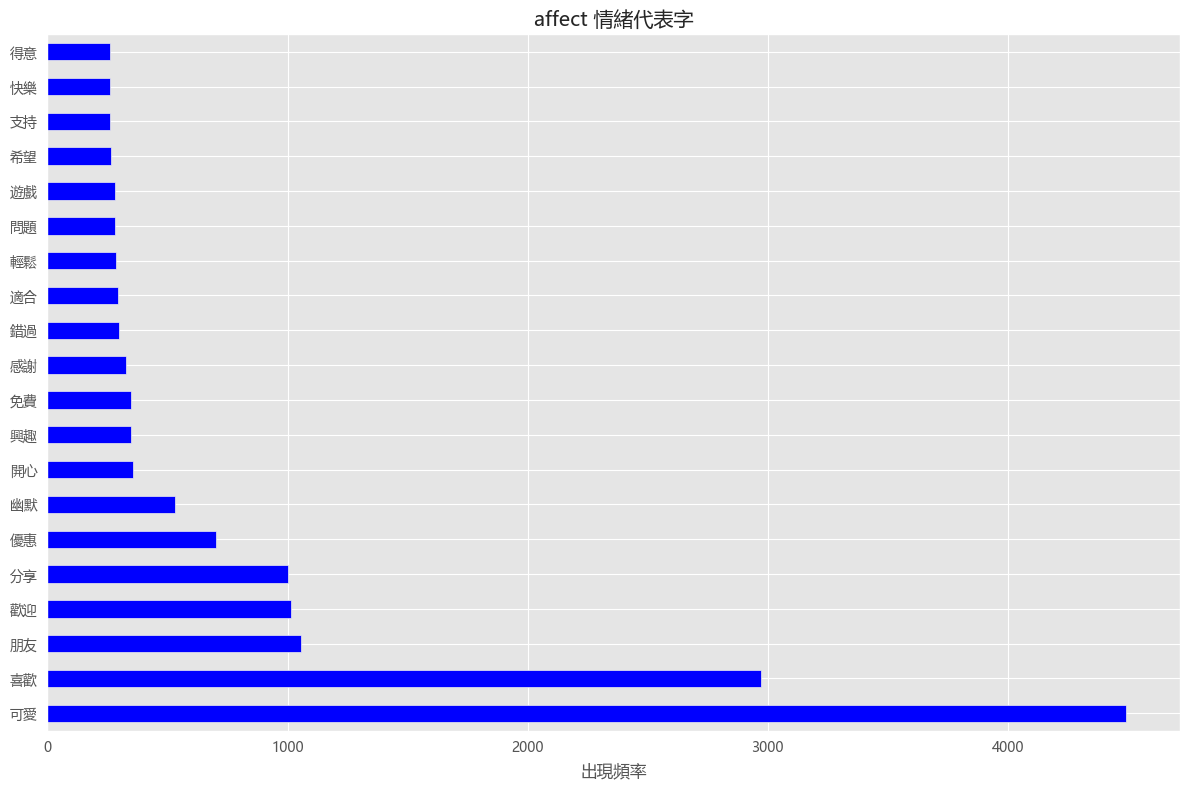

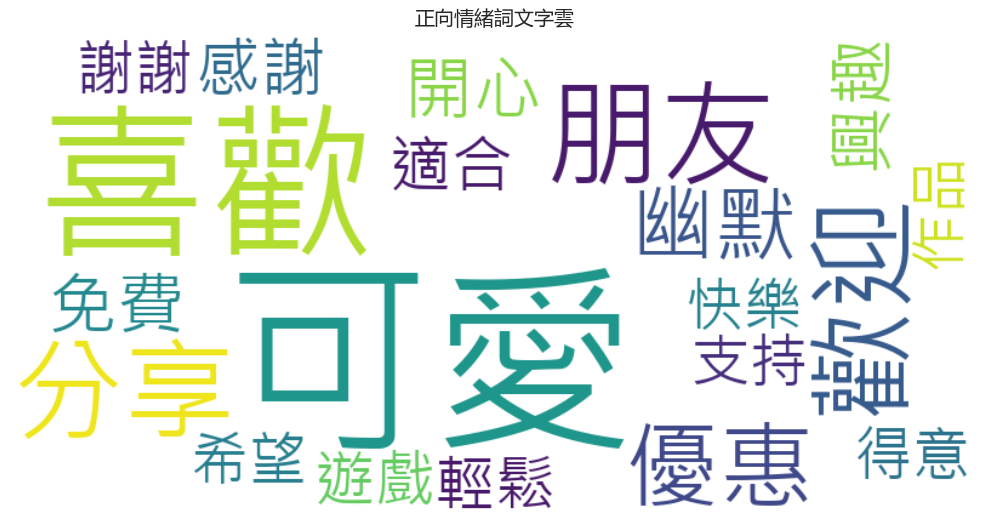

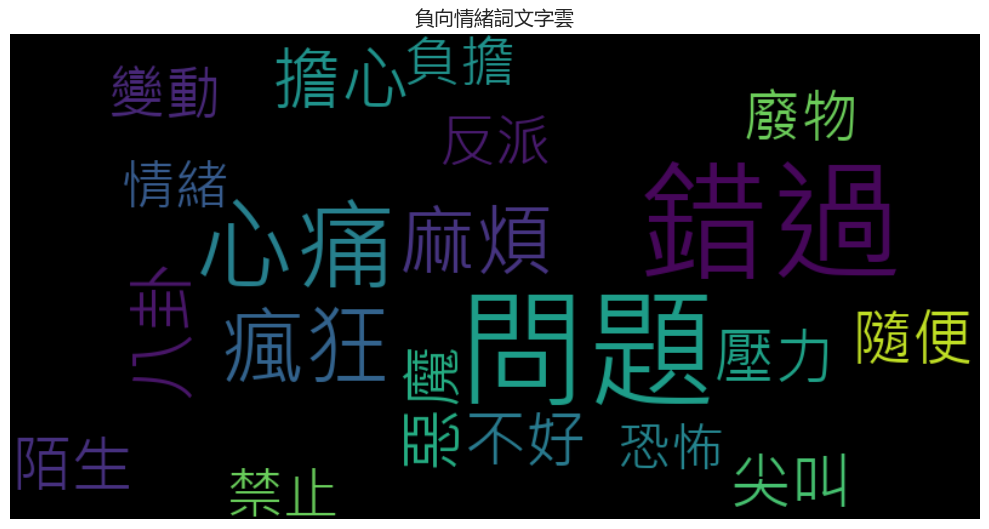

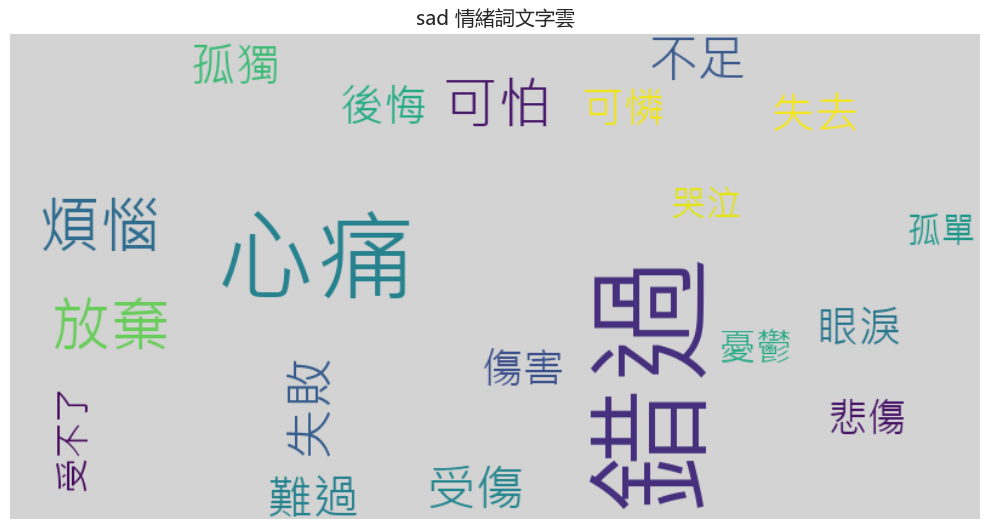

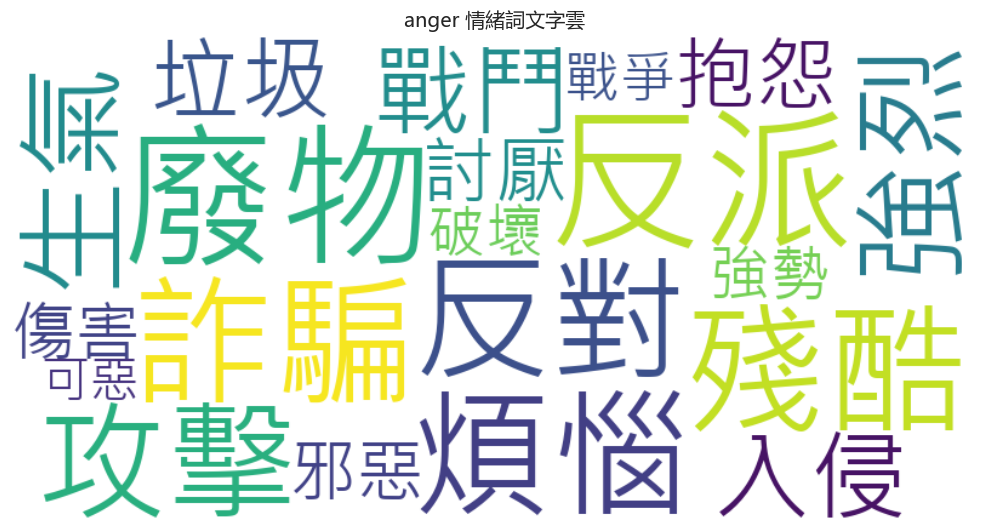

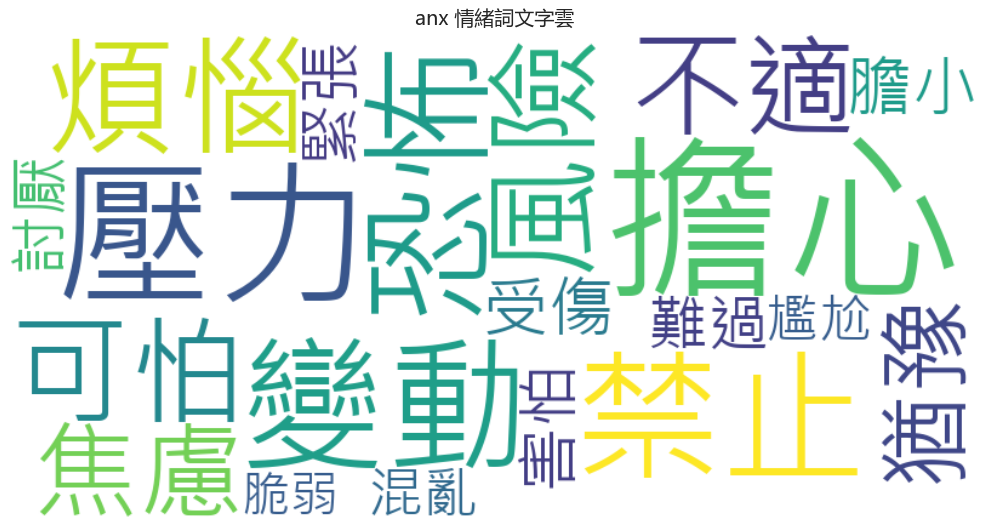

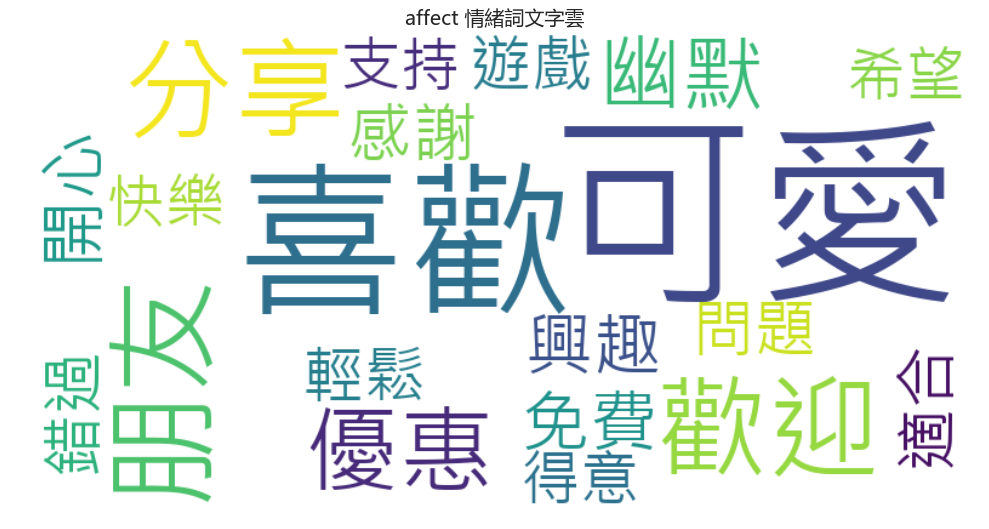

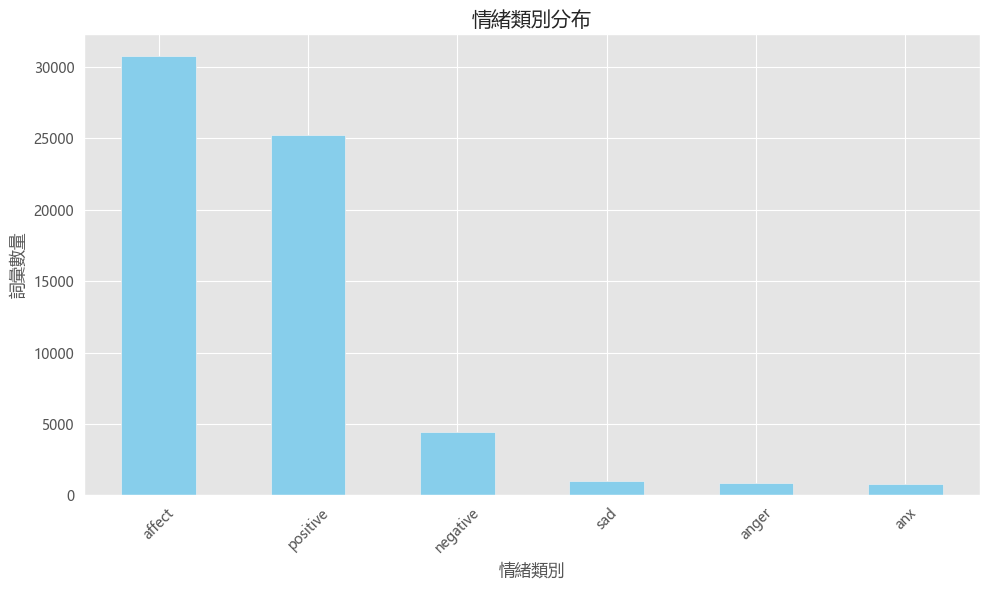

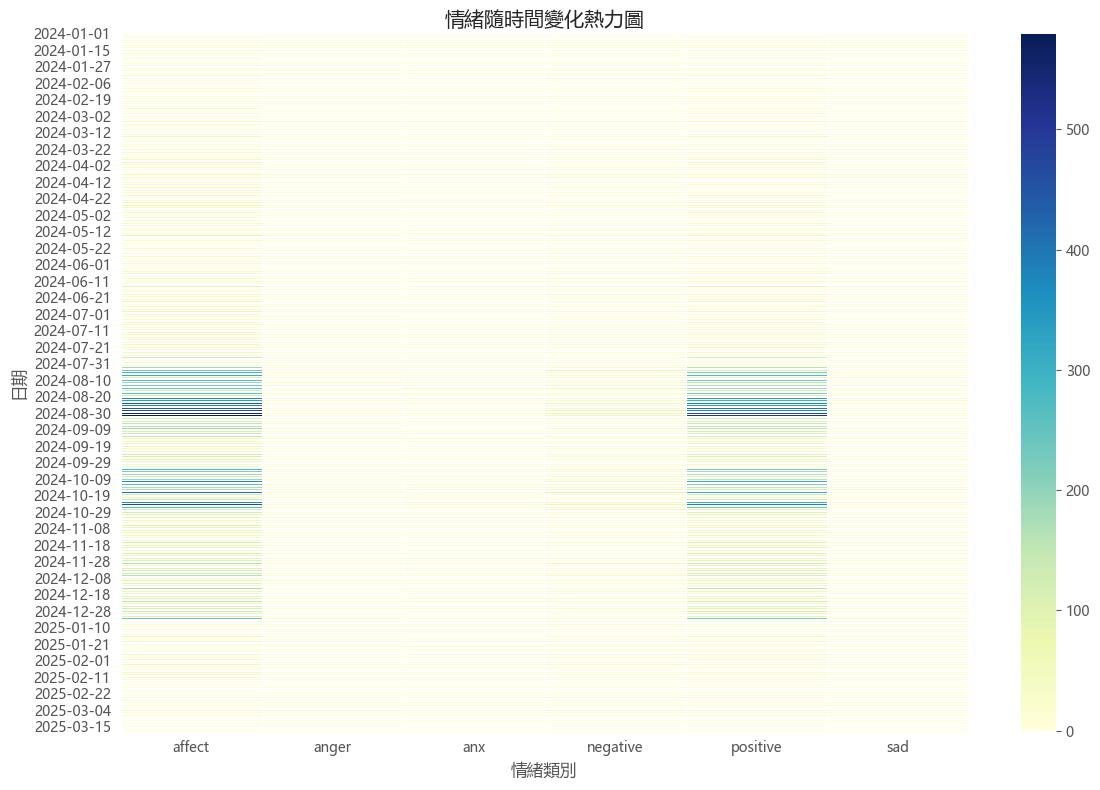

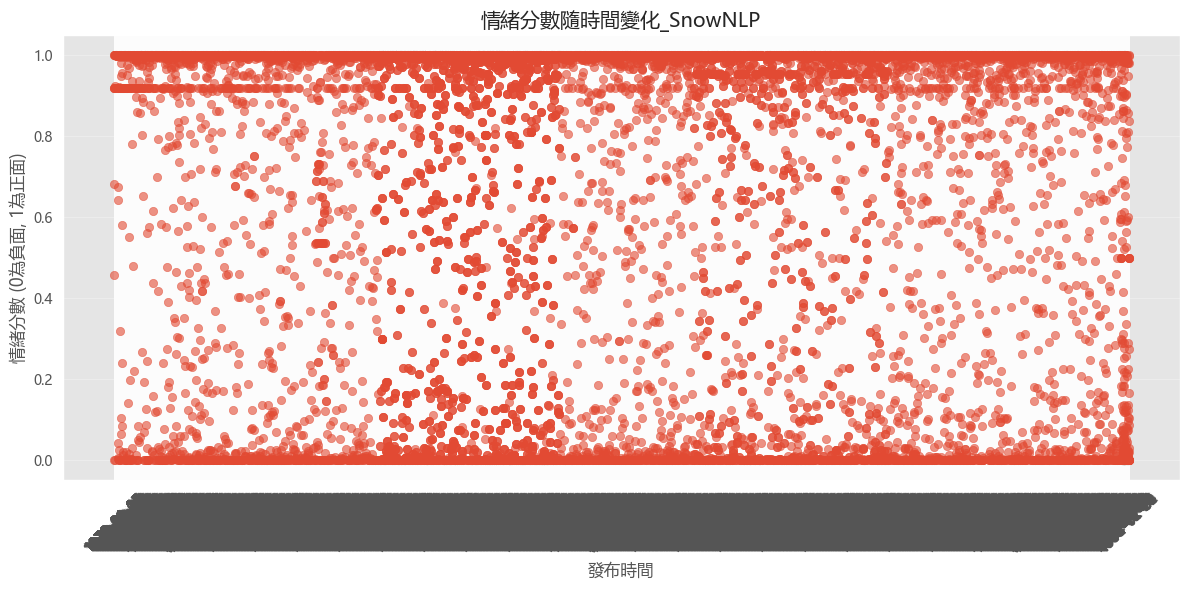

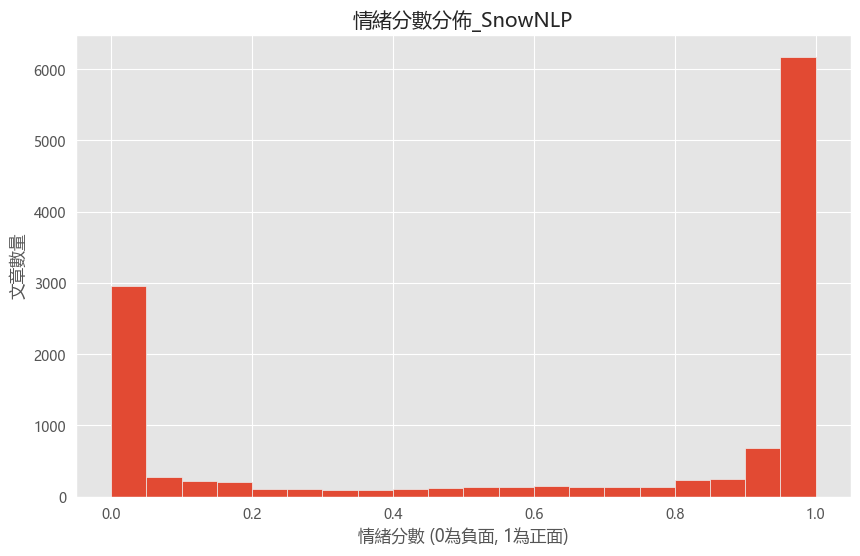

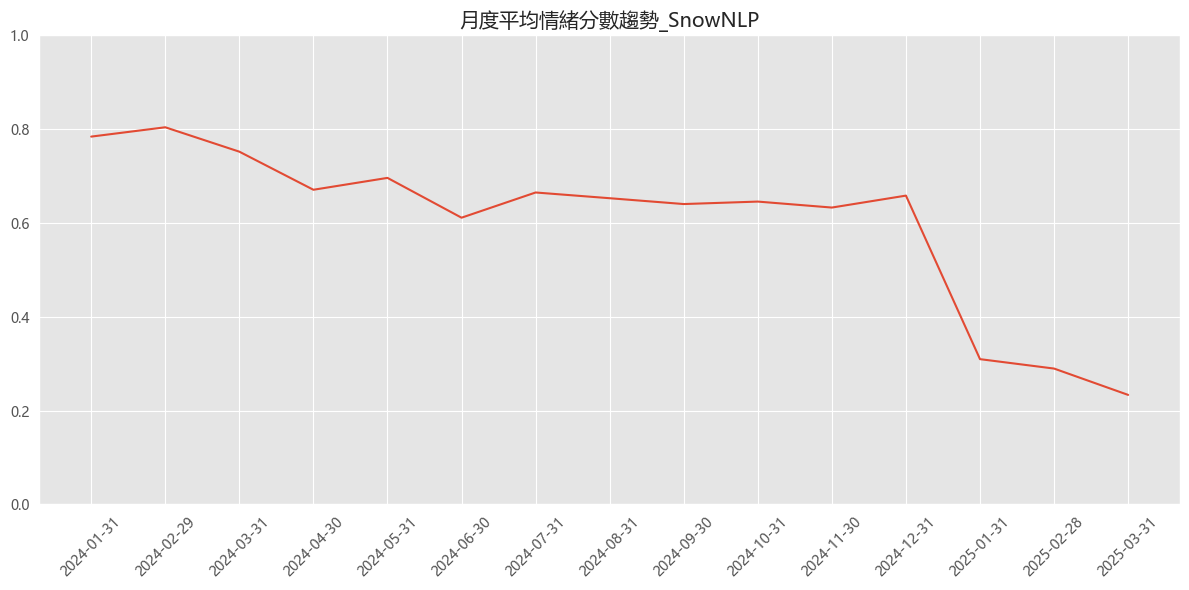

In [ ]:
# 載入情緒詞典 
liwc_dict = pd.read_csv("dict/liwc/LIWC_CH.csv")  
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

# 將分詞結果展開以便與情緒字典合併
word_df = df.explode('flat_tokens')
word_df = word_df[word_df['flat_tokens'].notnull() & (word_df['flat_tokens'] != '')]
word_df = word_df.rename(columns={'flat_tokens': 'word'})

# 合併情緒詞典
liwc_df = pd.merge(word_df[["artUrl", "artDate", "artContent", "word"]], 
                   liwc_dict, how="left", on="word")

# 確保日期格式正確
liwc_df['date'] = pd.to_datetime(liwc_df['artDate']).dt.date

# 計算每日情緒詞頻率
daily_sentiment = liwc_df.groupby(['date', 'sentiments']).size().unstack(fill_value=0)

# 繪製每日情緒詞頻率
plt.figure(figsize=(12, 6))
if 'positive' in daily_sentiment.columns:
    plt.plot(daily_sentiment.index, daily_sentiment['positive'], 'g-', label='正向情緒詞')
if 'negative' in daily_sentiment.columns:
    plt.plot(daily_sentiment.index, daily_sentiment['negative'], 'r-', label='負向情緒詞')

plt.title('每日正負向情緒詞彙頻率')
plt.xlabel('日期')
plt.ylabel('詞彙頻率')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 繪製正負向情緒詞比例
if 'positive' in daily_sentiment.columns and 'negative' in daily_sentiment.columns:
    # 計算正負向情緒詞比例，避免除以零
    total_emotions = daily_sentiment['positive'] + daily_sentiment['negative']
    daily_sentiment['pos_ratio'] = daily_sentiment['positive'] / total_emotions.replace(0, np.nan)
    daily_sentiment['neg_ratio'] = daily_sentiment['negative'] / total_emotions.replace(0, np.nan)

    plt.figure(figsize=(12, 6))
    plt.plot(daily_sentiment.index, daily_sentiment['pos_ratio'], 'g-', label='正向情緒比例')
    plt.plot(daily_sentiment.index, daily_sentiment['neg_ratio'], 'r-', label='負向情緒比例')
    plt.title('每日正負向情緒詞彙比例')
    plt.xlabel('日期')
    plt.ylabel('詞彙比例')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 計算每日情緒分數 (正向-負向)
if 'positive' in daily_sentiment.columns and 'negative' in daily_sentiment.columns:
    daily_sentiment['sentiment_score'] = daily_sentiment['positive'] - daily_sentiment['negative']

    plt.figure(figsize=(12, 6))
    plt.plot(daily_sentiment.index, daily_sentiment['sentiment_score'], 'b-')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('每日情緒分數趨勢')
    plt.xlabel('日期')
    plt.ylabel('情緒分數')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 依據每篇文章的情緒詞分析
article_sentiment = liwc_df.groupby(['artUrl', 'sentiments']).size().unstack(fill_value=0)

# 計算每篇文章的正負向情緒分數
if 'positive' in article_sentiment.columns and 'negative' in article_sentiment.columns:
    article_sentiment['sentiment_score'] = article_sentiment['positive'] - article_sentiment['negative']

    # 查看文章情緒分數分布
    plt.figure(figsize=(10, 6))
    plt.hist(article_sentiment['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
    plt.title('文章情緒分數分布')
    plt.xlabel('情緒分數')
    plt.ylabel('文章數量')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

# 統計情緒詞彙
def get_top_words(sentiment_type):
    # 過濾出非NaN情緒類別的詞彙
    filtered_df = liwc_df[liwc_df['sentiments'] == sentiment_type]
    if filtered_df.empty:
        return pd.Series([])
    words = filtered_df['word'].value_counts().head(20)
    return words

# 使用正確的情緒類別名稱
positive_words = get_top_words('positive')
negative_words = get_top_words('negative')

# 繪製正向情緒代表字
if not positive_words.empty:
    plt.figure(figsize=(12, 8))
    positive_words.plot(kind='barh', color='green')
    plt.title('正向情緒代表字')
    plt.xlabel('出現頻率')
    plt.tight_layout()
    plt.show()

# 繪製負向情緒代表字
if not negative_words.empty:
    plt.figure(figsize=(12, 8))
    negative_words.plot(kind='barh', color='red')
    plt.title('負向情緒代表字')
    plt.xlabel('出現頻率')
    plt.tight_layout()
    plt.show()

# 繪製其他情緒類別的代表字
other_sentiments = ['sad', 'anger', 'anx', 'affect']
colors = ['purple', 'orange', 'brown', 'blue']

for sentiment_type, color in zip(other_sentiments, colors):
    words = get_top_words(sentiment_type)
    if not words.empty:
        plt.figure(figsize=(12, 8))
        words.plot(kind='barh', color=color)
        plt.title(f'{sentiment_type} 情緒代表字')
        plt.xlabel('出現頻率')
        plt.tight_layout()
        plt.show()

# 製作情緒詞的文字雲
def generate_wordcloud(words_dict, title, color='white'):
    if not words_dict:
        print(f"沒有足夠的詞彙建立 {title}")
        return
        
    wordcloud = WordCloud(
        font_path='./font/msjh.ttc',  # 使用中文字體
        background_color=color,
        width=800,
        height=400,
        max_words=100
    ).generate_from_frequencies(words_dict)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 正向情緒詞文字雲
if not positive_words.empty:
    positive_dict = dict(positive_words)
    generate_wordcloud(positive_dict, '正向情緒詞文字雲', color='white')

# 負向情緒詞文字雲
if not negative_words.empty:
    negative_dict = dict(negative_words)
    generate_wordcloud(negative_dict, '負向情緒詞文字雲', color='black')

# 其他情緒類別文字雲
for sentiment_type in other_sentiments:
    words = get_top_words(sentiment_type)
    if not words.empty:
        words_dict = dict(words)
        bg_color = 'white' if sentiment_type != 'sad' else 'lightgray'
        generate_wordcloud(words_dict, f'{sentiment_type} 情緒詞文字雲', color=bg_color)

# 繪製所有情緒類別的分布情況
plt.figure(figsize=(10, 6))
sentiment_counts = liwc_df['sentiments'].value_counts()
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('情緒類別分布')
plt.xlabel('情緒類別')
plt.ylabel('詞彙數量')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 繪製情緒隨時間變化的熱力圖
sentiment_time = liwc_df.pivot_table(
    index='date', 
    columns='sentiments', 
    aggfunc='size', 
    fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_time, cmap='YlGnBu', linewidths=.5)
plt.title('情緒隨時間變化熱力圖')
plt.ylabel('日期')
plt.xlabel('情緒類別')
plt.tight_layout()
plt.show()



8. SnowNLP情緒分析

In [ ]:
# 使用SnowNLP進行第二階段的情緒分析，並確認 lambda 給 SnowNLP 的字串不會空
df['sentiment_score'] = df['clean_content'].apply(
    lambda x: SnowNLP(x).sentiments if isinstance(x, str) and x.strip() else 0.5
)

# 按時間排序
df_sorted = df.sort_values('artDate')

# 散點圖展示情緒隨時間變化
plt.figure(figsize=(12, 6))
plt.scatter(df_sorted['artDate'], df_sorted['sentiment_score'], alpha=0.6)
plt.title('情緒分數隨時間變化_SnowNLP')
plt.xlabel('發布時間')
plt.ylabel('情緒分數 (0為負面, 1為正面)')
plt.grid(True, alpha=0.3)

# 繪製時間軸
years_fmt = plt.matplotlib.dates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 繪製情緒分數分佈圖
plt.figure(figsize=(10, 6))
plt.hist(df['sentiment_score'], bins=20)
plt.title('情緒分數分佈_SnowNLP') # 標題可以區分一下
plt.xlabel('情緒分數 (0為負面, 1為正面)')
plt.ylabel('文章數量')
plt.show()

# 將日期轉換為時間索引並計算月度平均情緒分數
df['artDate'] = pd.to_datetime(df['artDate']) # 確保是 Timestamp
monthly_sentiment = df.set_index('artDate').resample('M')['sentiment_score'].mean() 

# 繪製月度情緒趨勢圖
plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment.index.astype(str), monthly_sentiment.values)
plt.title('月度平均情緒分數趨勢_SnowNLP')
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

9. TF-IDF分析與主題建模

前20個最重要詞彙 (基於平均TF-IDF):
日本       0.055930
代購       0.052809
銅鑼灣      0.049382
公仔       0.045378
兔兔       0.044553
小八貓      0.035842
可愛       0.031493
喜歡       0.027042
迷因       0.026059
香港       0.025921
玩具       0.025161
又小又可愛    0.024369
扭蛋       0.022351
追蹤       0.021777
購物       0.020968
壽司       0.020509
百貨       0.020356
時代廣場     0.019813
電視對面     0.019712
小桃       0.019204
dtype: float64


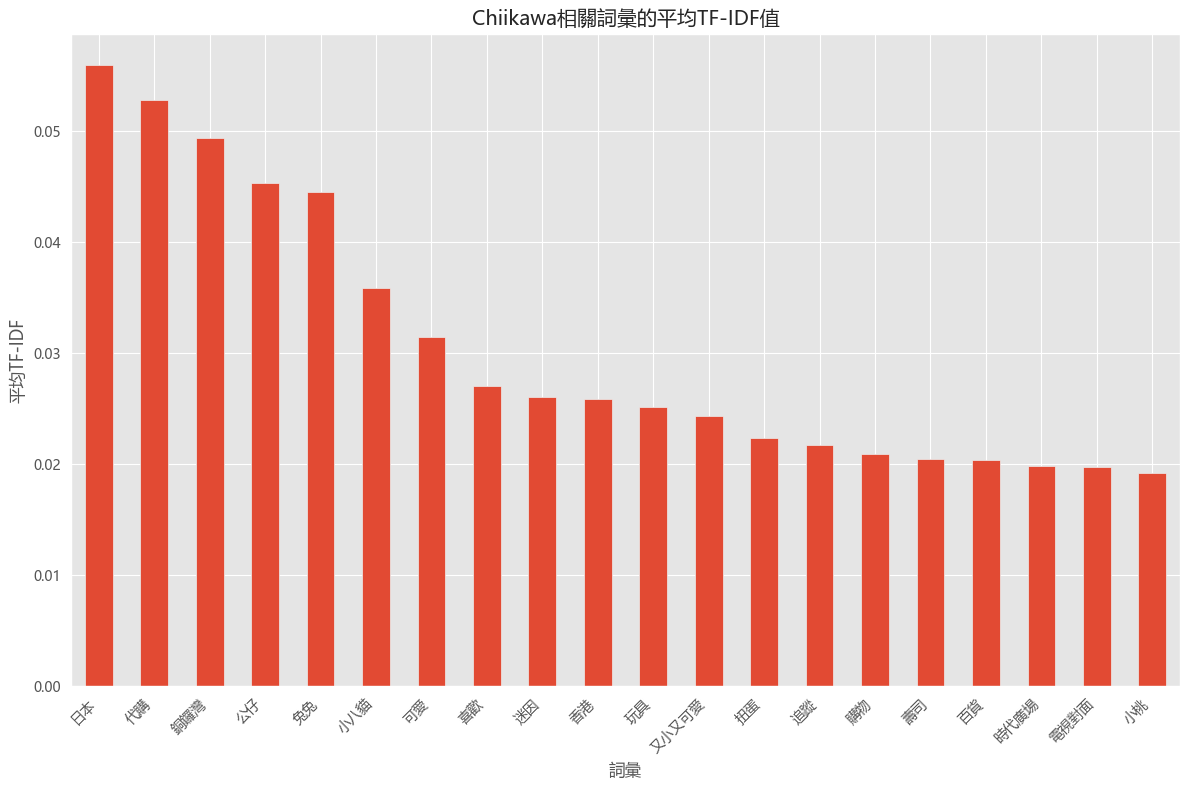


文章 1:
標題: [閒聊] 轉生到吉伊卡哇的世界有辦法生存嗎
來源: PTT
重要詞彙:
  - 辦法: 0.5229
  - 有人: 0.4698
  - 生物: 0.4614
  - 知道: 0.4083
  - 世界: 0.3554

文章 2:
標題: 無標題(Instagram)
來源: IG
重要詞彙:
  - 好人: 0.5029
  - 開箱: 0.4997
  - 看到: 0.4175
  - 台北: 0.4097
  - 生活: 0.3941

文章 3:
標題: 【雜談】藏壽司吉伊卡哇扭蛋戰果報告！究竟楓梨當天吃了幾盤？最後有抽到嗎？？【 砂糖楓梨 Sato Furi 】
來源: YT
重要詞彙:
  - 直播: 0.4940
  - 尊重: 0.2745
  - 老師: 0.2577
  - 話題: 0.2492
  - 傳送門: 0.2488

文章 4:
標題: 無標題(Instagram)
來源: IG
重要詞彙:
  - 銅鑼灣: 0.5108
  - 兔兔: 0.2674
  - 公仔: 0.2269
  - 電視對面: 0.2077
  - 時代廣場: 0.2074

文章 5:
標題: 無標題(Instagram)
來源: IG
重要詞彙:
  - 銅鑼灣: 0.4851
  - 多款: 0.2902
  - 扭蛋: 0.2644
  - 日本: 0.2306
  - 公仔: 0.2155


In [47]:
# 首先確保dataframe中的token列已準備好
# 合併文檔中的token，轉為字符串以供sklearn使用
df['token_text'] = df['flat_tokens'].apply(
    lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else ''
)

# 創建TF-IDF向量化器
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # 最多保留1000個特徵詞
    min_df=5,           # 至少出現在5個文檔中
    max_df=0.8,         # 最多出現在80%的文檔中
)

# 轉換文檔
tfidf_matrix = tfidf_vectorizer.fit_transform(df['token_text'].fillna(''))

# 獲取特徵詞列表
feature_names = tfidf_vectorizer.get_feature_names_out()

# 將TF-IDF矩陣轉換為DataFrame以方便查看
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# 計算每個詞的平均TF-IDF值
avg_tfidf = tfidf_df.mean().sort_values(ascending=False)

# 顯示前20個最重要的詞
print("前20個最重要詞彙 (基於平均TF-IDF):")
print(avg_tfidf.head(20))

# 可視化前20個詞的TF-IDF值
plt.figure(figsize=(12, 8))
avg_tfidf.head(20).plot(kind='bar')
plt.title('Chiikawa相關詞彙的平均TF-IDF值')
plt.xlabel('詞彙')
plt.ylabel('平均TF-IDF')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 找出每篇文章中最重要的詞彙
top_words_per_doc = []
for i, row in enumerate(tfidf_matrix.toarray()):
    # 獲取TF-IDF值最高的5個詞的索引
    top_indices = row.argsort()[-5:][::-1]
    # 獲取這些詞
    top_words = [(feature_names[idx], row[idx]) for idx in top_indices]
    top_words_per_doc.append(top_words)

# 將最重要的詞加入到原始DataFrame
df['top_tfidf_words'] = top_words_per_doc

# 隨機顯示5篇文章的標題及其重要詞彙
sample_docs = df.sample(5)
for i, (idx, doc) in enumerate(sample_docs.iterrows()):
    print(f"\n文章 {i+1}:")
    print(f"標題: {doc['artTitle'] if doc['artTitle'] else '無標題(Instagram)'}")
    print(f"來源: {doc['dataSource']}")
    print("重要詞彙:")
    for word, score in doc['top_tfidf_words']:
        print(f"  - {word}: {score:.4f}")

10.文檔相似度分析與聚類

與文章 1 最相似的文章:
文章 9: 相似度 1.0000
標題: 【Chiikawa】睡衣派對之歌 / パジャマパーティーズのうた 廣東話歌詞...
--------------------------------------------------
文章 6926: 相似度 0.8177
標題: ...
--------------------------------------------------
文章 21: 相似度 0.8177
標題: 打開 Illustrator 嗚哇哇嗚挖就做好了吉伊卡哇軟糖🐻‍❄️...
--------------------------------------------------
文章 3177: 相似度 0.8177
標題: ...
--------------------------------------------------
文章 11404: 相似度 0.7069
標題: ...
--------------------------------------------------
各聚類文章數量:
0    1163
1     931
2     510
3    9623
4     252
Name: cluster, dtype: int64


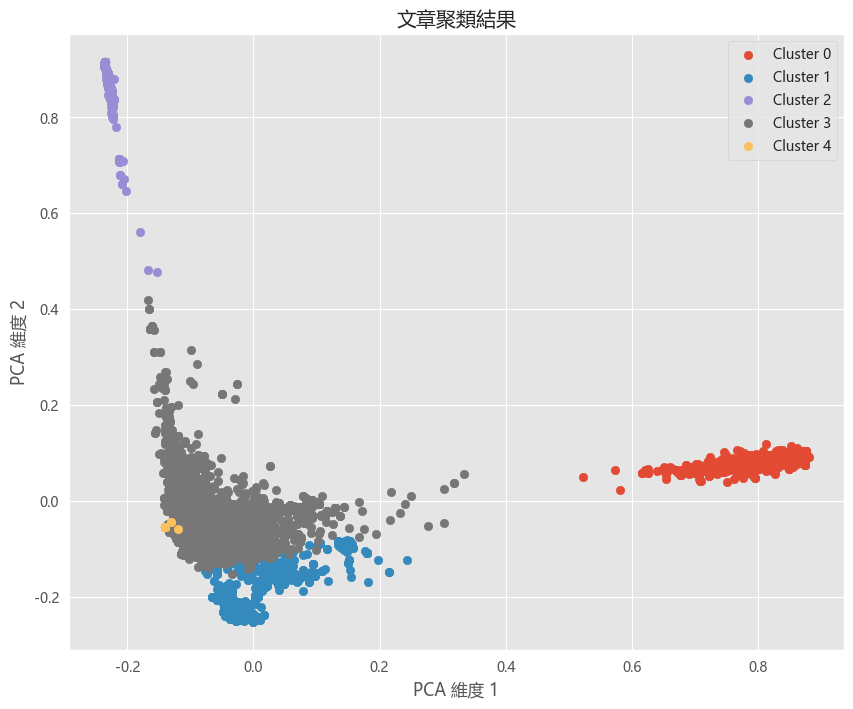

各聚類關鍵詞:
  Cluster 0 Cluster 1 Cluster 2 Cluster 3 Cluster 4
0       銅鑼灣        代購        迷因        日本     又小又可愛
1      時代廣場        旺角        追蹤        兔兔        華山
2      電視對面        八字        喜歡       小八貓        閃店
3        百貨        日本        翻譯        可愛        傢伙
4        公仔        公仔        幽默        壽司        網上


In [56]:
# 計算所有文檔之間的餘弦相似度
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 創建相似度DataFrame方便查看
similarity_df = pd.DataFrame(cosine_sim, 
                            index=df.index, 
                            columns=df.index)

# 例如，查看第1篇文章與其他所有文章的相似度
article_id = 1  # 假設我們要檢查的文章ID
similar_articles = similarity_df[article_id].sort_values(ascending=False)

# 打印前5個最相似的文章(不包括自己)
print("與文章 {} 最相似的文章:".format(article_id))
for idx, score in similar_articles[1:6].items():
    print(f"文章 {idx}: 相似度 {score:.4f}")
    
    # 處理標題可能是非字符串的情況
    title = df.loc[idx, 'artTitle']
    if isinstance(title, str):
        print(f"標題: {title[:50]}...")  # 打印部分標題
    else:
        print(f"標題: {str(title)}")
    
    print("-" * 50)

# 選擇合適的聚類數量，這裡假設為5
num_clusters = 5

# 使用K-means聚類
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(tfidf_matrix)

# 獲取聚類標籤
clusters = km.labels_

# 將聚類結果添加到原始數據框
df['cluster'] = clusters

# 查看每個聚類的文章數量
cluster_counts = df['cluster'].value_counts().sort_index()
print("各聚類文章數量:")
print(cluster_counts)

# 可視化聚類結果 (使用PCA降維到2D空間)
from sklearn.decomposition import PCA

# 降維到2D
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# 繪製散點圖
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    # 獲取屬於第i個聚類的點
    points = reduced_features[clusters == i]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')

plt.title('文章聚類結果')
plt.xlabel('PCA 維度 1')
plt.ylabel('PCA 維度 2')
plt.legend()
plt.show()

# 分析每個聚類的關鍵詞
def get_top_keywords(tfidf_vectorizer, tfidf_matrix, clusters, n_terms=5):
    df_keywords = pd.DataFrame()
    # 獲取特徵名稱(詞彙)
    terms = tfidf_vectorizer.get_feature_names_out()
    
    for i in range(num_clusters):
        # 獲取第i個聚類的所有文檔
        docs_in_cluster = tfidf_matrix[clusters == i].toarray()
        # 計算該聚類中每個詞的平均TF-IDF值
        centroid = docs_in_cluster.mean(axis=0)
        # 獲取排名前n的詞的索引
        top_indices = centroid.argsort()[-n_terms:][::-1]
        # 獲取這些詞
        top_terms = [terms[j] for j in top_indices]
        
        df_keywords[f'Cluster {i}'] = top_terms
        
    return df_keywords

# 獲取並顯示每個聚類的關鍵詞
top_keywords = get_top_keywords(tfidf_vectorizer, tfidf_matrix, clusters)
print("各聚類關鍵詞:")
print(top_keywords)

11. N-gram語言模型(記憶體不足跑不太動)

In [52]:
# 確保token列已準備好，然後構建更完善的語料庫
tokenized_docs = df['flat_tokens'].tolist()
tokenized_docs = [doc for doc in tokenized_docs if isinstance(doc, list) and doc]

# 構建Bigram和Trigram頻率表
bigram_counts = defaultdict(Counter)
trigram_counts = defaultdict(Counter)

# 統計Bigram和Trigram頻率
for doc in tokenized_docs:
    for i in range(len(doc) - 1):
        # Bigram: 記錄第一個詞後面接第二個詞的頻率
        first_word = doc[i]
        next_word = doc[i + 1]
        bigram_counts[first_word][next_word] += 1
        
        # Trigram: 記錄前兩個詞後面接第三個詞的頻率
        if i < len(doc) - 2:
            first_two_words = (doc[i], doc[i + 1])
            next_word = doc[i + 2]
            trigram_counts[first_two_words][next_word] += 1

# 轉換為條件概率
bigram_probs = defaultdict(dict)
trigram_probs = defaultdict(dict)

# 計算Bigram條件概率 P(w2|w1)
for first_word, counter in bigram_counts.items():
    total_count = sum(counter.values())
    for next_word, count in counter.items():
        bigram_probs[first_word][next_word] = count / total_count

# 計算Trigram條件概率 P(w3|w1,w2)
for first_two_words, counter in trigram_counts.items():
    total_count = sum(counter.values())
    for next_word, count in counter.items():
        trigram_probs[first_two_words][next_word] = count / total_count

# 預測函數：給定前一個或前兩個詞，預測下一個詞
def predict_next_word(prev_words, model='bigram'):
    if model == 'bigram' and len(prev_words) >= 1:
        prev_word = prev_words[-1]
        if prev_word in bigram_probs:
            # 按概率降序排序
            sorted_words = sorted(bigram_probs[prev_word].items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)
            return sorted_words[:5]  # 返回前5個最可能的詞
    
    elif model == 'trigram' and len(prev_words) >= 2:
        prev_two_words = (prev_words[-2], prev_words[-1])
        if prev_two_words in trigram_probs:
            sorted_words = sorted(trigram_probs[prev_two_words].items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)
            return sorted_words[:5]
    
    return []  # 如果沒有匹配的模式或前一個詞不在模型中，返回空列表

# 測試預測
test_words = ['吉伊卡哇']
bigram_predictions = predict_next_word(test_words, 'bigram')
print(f"使用Bigram模型，'{test_words[-1]}'後面最可能的詞:")
for word, prob in bigram_predictions:
    print(f"{word}: {prob:.4f}")

# 生成文本函數
def generate_text(seed_words, model='bigram', length=20):
    if not seed_words:
        # 隨機選擇一個詞作為起始
        all_words = list(bigram_probs.keys())
        text = [random.choice(all_words)]
    else:
        text = list(seed_words)
    
    for _ in range(length):
        if model == 'bigram':
            prev_word = text[-1]
            if prev_word in bigram_probs and bigram_probs[prev_word]:
                # 按概率抽樣
                words, probs = zip(*bigram_probs[prev_word].items())
                probs = np.array(probs) / sum(probs)  # 確保概率總和為1
                next_word = np.random.choice(words, p=probs)
                text.append(next_word)
            else:
                # 如果前一個詞不在模型中，隨機選擇一個詞
                all_words = list(bigram_probs.keys())
                text.append(random.choice(all_words))
        
        elif model == 'trigram' and len(text) >= 2:
            prev_two_words = (text[-2], text[-1])
            if prev_two_words in trigram_probs and trigram_probs[prev_two_words]:
                words, probs = zip(*trigram_probs[prev_two_words].items())
                probs = np.array(probs) / sum(probs)
                next_word = np.random.choice(words, p=probs)
                text.append(next_word)
            else:
                # 回退到bigram模型
                prev_word = text[-1]
                if prev_word in bigram_probs and bigram_probs[prev_word]:
                    words, probs = zip(*bigram_probs[prev_word].items())
                    probs = np.array(probs) / sum(probs)
                    next_word = np.random.choice(words, p=probs)
                    text.append(next_word)
                else:
                    all_words = list(bigram_probs.keys())
                    text.append(random.choice(all_words))
    
    return text

# 測試生成文本
seed_words = ['吉伊卡哇']
generated_text = generate_text(seed_words, model='bigram', length=15)
print(f"使用Bigram模型生成的文本 (種子詞: {' '.join(seed_words)}):")
print(' '.join(generated_text))

# 評估函數：計算模型在測試文本上的困惑度
def calculate_perplexity(test_docs, model='bigram'):
    log_prob_sum = 0
    token_count = 0
    
    for doc in test_docs:
        for i in range(1, len(doc)):
            prev_word = doc[i-1]
            current_word = doc[i]
            
            if model == 'bigram':
                # 如果前一個詞在模型中並且當前詞在條件概率中
                if prev_word in bigram_probs and current_word in bigram_probs[prev_word]:
                    prob = bigram_probs[prev_word][current_word]
                    log_prob_sum += log(prob, 2)
                else:
                    # 使用平滑處理，避免概率為0
                    log_prob_sum += log(1e-10, 2)
            
            token_count += 1
    
    if token_count == 0:
        return float('inf')
    
    # 計算困惑度：2的負平均對數概率次方
    perplexity = 2 ** (-log_prob_sum / token_count)
    return perplexity

# 拆分數據集為訓練集和測試集
train_docs, test_docs = train_test_split(tokenized_docs, test_size=0.2, random_state=42)

# 計算測試集上的困惑度
perplexity = calculate_perplexity(test_docs, model='bigram')
print(f"Bigram模型在測試集上的困惑度: {perplexity:.2f}")

使用Bigram模型，'吉伊卡哇'後面最可能的詞:
吉伊卡哇: 0.2285
代購: 0.0880
公仔: 0.0556
小八貓: 0.0439
兔兔: 0.0244
使用Bigram模型生成的文本 (種子詞: 吉伊卡哇):
吉伊卡哇 绝区 吉伊卡哇 吉伊卡哇 壽司 系列 超級 可愛 突擊 壽司 吉伊卡哇 吉伊卡哇 小八貓 兔兔 師傅 師父
Bigram模型在測試集上的困惑度: 15.53


12. 語言模型平滑化技術(記憶體不足跑不太動)

In [ ]:
# 使用加一平滑（Laplace Smoothing）改進Bigram模型
def build_smoothed_bigram_model(docs, vocabulary=None):
    # 如果沒有提供詞彙表，從文檔中構建
    if vocabulary is None:
        vocabulary = set()
        for doc in docs:
            vocabulary.update(doc)
    vocab_size = len(vocabulary)
    
    # 計數
    bigram_counts = defaultdict(Counter)
    word_counts = Counter()
    
    for doc in docs:
        for i in range(len(doc) - 1):
            first_word = doc[i]
            next_word = doc[i + 1]
            bigram_counts[first_word][next_word] += 1
            word_counts[first_word] += 1
    
    # 應用加一平滑
    smoothed_probs = defaultdict(dict)
    for first_word in word_counts:
        for next_word in vocabulary:
            # 計算P(next_word|first_word)的平滑概率
            # (count(first_word, next_word) + 1) / (count(first_word) + |V|)
            count = bigram_counts[first_word][next_word]
            total = word_counts[first_word]
            smoothed_probs[first_word][next_word] = (count + 1) / (total + vocab_size)
    
    return smoothed_probs

# 使用Kneser-Ney平滑构建改進的N-gram模型
def kneser_ney_smoothing(train_docs, discount=0.75):
    # 統計Bigram頻次
    bigram_counts = defaultdict(Counter)
    word_counts = Counter()
    
    for doc in train_docs:
        for i in range(len(doc) - 1):
            first_word = doc[i]
            next_word = doc[i + 1]
            bigram_counts[first_word][next_word] += 1
            word_counts[first_word] += 1
    
    # 計算每個詞作為下文出現的不同上文數量
    word_following_count = Counter()
    for first_word, follows in bigram_counts.items():
        for next_word in follows:
            word_following_count[next_word] += 1
    
    # 計算Kneser-Ney平滑的概率
    kn_probs = defaultdict(dict)
    
    for first_word in word_counts:
        denom = word_counts[first_word]
        unique_follows = len(bigram_counts[first_word])
        
        for next_word in bigram_counts[first_word]:
            count = bigram_counts[first_word][next_word]
            
            # 計算Kneser-Ney概率
            # P_KN(w2|w1) = max(count(w1,w2) - d, 0) / count(w1) + λ * P_continuation(w2)
            kn_probs[first_word][next_word] = max(count - discount, 0) / denom
    
    # 計算λ和後備概率
    for first_word in word_counts:
        denom = word_counts[first_word]
        unique_follows = len(bigram_counts[first_word])
        
        # λ(w1) = d * unique_follows(w1) / count(w1)
        lambda_w1 = discount * unique_follows / denom
        
        # 為所有在訓練集中出現的詞添加後備概率
        for next_word in word_following_count:
            if next_word not in kn_probs[first_word]:
                # P_continuation(w2) = count_unique_history(w2) / count_unique_bigrams
                continuation_prob = word_following_count[next_word] / len(bigram_counts)
                kn_probs[first_word][next_word] = lambda_w1 * continuation_prob
            else:
                continuation_prob = word_following_count[next_word] / len(bigram_counts)
                kn_probs[first_word][next_word] += lambda_w1 * continuation_prob
    
    return kn_probs

# 使用改進後的模型進行測試
# 構建平滑後的Bigram模型
all_words = set()
for doc in tokenized_docs:
    all_words.update(doc)

smoothed_bigram_probs = build_smoothed_bigram_model(train_docs, all_words)

# 測試預測
test_words = ['吉伊卡哇']
smoothed_predictions = []
prev_word = test_words[-1]

if prev_word in smoothed_bigram_probs:
    # 按概率降序排序
    smoothed_predictions = sorted(smoothed_bigram_probs[prev_word].items(), 
                                 key=lambda x: x[1], 
                                 reverse=True)[:5]

print("\n使用加一平滑後的Bigram模型:")
print(f"'{test_words[-1]}'後面最可能的詞:")
for word, prob in smoothed_predictions:
    print(f"{word}: {prob:.6f}")

# 計算改進後模型的困惑度
def calculate_smoothed_perplexity(test_docs, smoothed_probs):
    log_prob_sum = 0
    token_count = 0
    
    for doc in test_docs:
        for i in range(1, len(doc)):
            prev_word = doc[i-1]
            current_word = doc[i]
            
            if prev_word in smoothed_probs and current_word in smoothed_probs[prev_word]:
                prob = smoothed_probs[prev_word][current_word]
                log_prob_sum += log(prob, 2)
            else:
                # 使用非常小的概率代替0，避免無窮大
                log_prob_sum += log(1e-10, 2)
            
            token_count += 1
    
    if token_count == 0:
        return float('inf')
    
    perplexity = 2 ** (-log_prob_sum / token_count)
    return perplexity

smoothed_perplexity = calculate_smoothed_perplexity(test_docs, smoothed_bigram_probs)
print(f"\n加一平滑後的Bigram模型在測試集上的困惑度: {smoothed_perplexity:.2f}")

##總結報告##

In [58]:
print("\n========== 社群媒體分析結果總結 ==========")
print(f"分析資料來源: YouTube, PTT, Instagram")
print(f"分析文章總數: {len(df)}")
print(f"平台分布: {df['dataSource'].value_counts().to_dict()}")
print(f"時間範圍: {pd.to_datetime(df['artDate']).min().strftime('%Y-%m-%d')} 至 {pd.to_datetime(df['artDate']).max().strftime('%Y-%m-%d')}")
print("\n主要高頻詞彙:")
for word, count in word_counts.head(10).values:
    print(f"  - {word}: {count}次")
    
print("\n文本聚類結果:")
for i in range(num_clusters):
    cluster_size = (df['cluster'] == i).sum()
    top_terms = top_keywords[f'Cluster {i}'].values
    print(f"  - 聚類 {i} ({cluster_size}篇): {', '.join(top_terms)}")

print("\n情緒分析結果:")
if 'positive' in daily_sentiment.columns and 'negative' in daily_sentiment.columns:
    overall_positive = daily_sentiment['positive'].sum()
    overall_negative = daily_sentiment['negative'].sum()
    overall_ratio = overall_positive / (overall_positive + overall_negative) if (overall_positive + overall_negative) > 0 else 0
    print(f"  - 整體正向情緒詞比例: {overall_ratio:.2%}")
    print(f"  - 情緒分數平均值: {df['sentiment_score'].mean():.4f}")
    print(f"  - 情緒分數中位數: {df['sentiment_score'].median():.4f}")


========== 社群媒體分析結果總結 ==========
分析資料來源: YouTube, PTT, Instagram
分析文章總數: 12479
平台分布: {'IG': 11156, 'PTT': 861, 'YT': 462}
時間範圍: 2024-01-01 至 2025-03-16

主要高頻詞彙:
  - 吉伊卡哇: 28964次
  - 日本: 11436次
  - 代購: 9272次
  - 公仔: 7858次
  - 兔兔: 6368次
  - 銅鑼灣: 6101次
  - 可愛: 4493次
  - 小八貓: 4146次
  - 香港: 3896次
  - 玩具: 3481次

文本聚類結果:
  - 聚類 0 (1163篇): 銅鑼灣, 時代廣場, 電視對面, 百貨, 公仔
  - 聚類 1 (931篇): 代購, 旺角, 八字, 日本, 公仔
  - 聚類 2 (510篇): 迷因, 追蹤, 喜歡, 翻譯, 幽默
  - 聚類 3 (9623篇): 日本, 兔兔, 小八貓, 可愛, 壽司
  - 聚類 4 (252篇): 又小又可愛, 華山, 閃店, 傢伙, 網上

情緒分析結果:
  - 整體正向情緒詞比例: 85.04%
  - 情緒分數平均值: 0.6453
  - 情緒分數中位數: 0.9442
